# K-NN on Amazon Review Dataset

In [141]:
#import libraries.....
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer


#nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import time
import datetime
from tqdm import tqdm
from prettytable import PrettyTable

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [142]:
start=time.time()
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite') 
final_tbs=pd.read_sql_query("""select * from Reviews""",con)
con.close()

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

final_tbs.head(5)

00:00:00


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [143]:
#Already done in the loaded file.
'''
final_tbs=final_tbs.sort_values(by=['Time'],ascending=True) # sorted data using Time feature as we need time based splitting
#readable = datetime.datetime.fromtimestamp(1536944119).isoformat()
#print(readable)
final_tbs.head(5)'''

"\nfinal_tbs=final_tbs.sort_values(by=['Time'],ascending=True) # sorted data using Time feature as we need time based splitting\n#readable = datetime.datetime.fromtimestamp(1536944119).isoformat()\n#print(readable)\nfinal_tbs.head(5)"

In [144]:
final_tbs['Score'].value_counts()

positive    51127
negative     8873
Name: Score, dtype: int64

In [145]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

print(final_tbs['Score'].value_counts())

final_tbs.head(5)

1    51127
0     8873
Name: Score, dtype: int64


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [146]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [147]:
final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary,Summary_CleanedText
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,everi book educ witti littl book make son laug...
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child,whole seri great way spend time child rememb s...
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni,entertainingl funni beetlejuic well written mo...
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale,modern day fairi tale twist rumplestiskin capt...
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,fantast beetlejuic excel funni movi keaton hil...


In [148]:
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [149]:
def kdtree_brute(alg,train_std_data,cv_std_data,test_std_data,y_tr,y_cv,y_test):
  
    start=time.time()
    
    # creating odd list of K for KNN
    #myList = list(range(0,30))
    #neighbors = list(filter(lambda x: x % 2 != 0, myList))
    neighbors = [5,7,9,11,13,17,19]
    
    cv_scores=[]

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=alg)
        knn.fit(train_std_data, y_tr)      
        pred=knn.predict(cv_std_data)       
        f1 = metrics.f1_score(y_cv,pred)       
        cv_scores.append(f1)

    
    #MSE = [1-x for x in cv_scores] # Misclassification error
    print(cv_scores)
    optimal_k = neighbors[cv_scores.index(max(cv_scores))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, cv_scores)

    for xy in zip(neighbors, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('cv_scores')
    plt.show()

    print("the cv_scores for each k value is : ", np.round(cv_scores,3))
    
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

    # fitting the model
    knn_optimal.fit(train_std_data, y_tr)   
    
    # predict the response
    pred = knn_optimal.predict(test_std_data)
    
    print("----"*20)
    
    # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier[Test data] for k = %d is %f%%' % (optimal_k, acc))

    # Precision
    precision = metrics.precision_score(y_test, pred)*100
    print('\nThe precision of the Knn classifier[Test data] for k = %d is %f%%' % (optimal_k, precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred)*100
    print('\nThe recall of the Knn classifier[Test data] for k = %d is %f%%' % (optimal_k, recall))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred)*100
    print('\nThe F1_score of the Knn classifier[Test data] for k = %d is %f%%' % (optimal_k, f1_score))
    
    print("----"*20)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))

In [150]:
# split the data set into train and test
y = np.array(final_tbs['Score'])

In [151]:
#Splitting whole data into Train,Cv,and Test datasets
X_1, test_df, y_1, y_test = train_test_split(final_tbs, y, test_size=0.20, random_state=43,shuffle=False)

train_df, cv_df, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.20,random_state=43,shuffle=False)

# Bow

In [152]:
#BoW
count_vect = CountVectorizer(min_df=50,max_features=2000) #in scikit-learn

train_bows = count_vect.fit_transform(train_df['Summary_CleanedText'])
cv_bows = count_vect.transform(cv_df['Summary_CleanedText'])
test_bows = count_vect.transform(test_df['Summary_CleanedText'])

train_std_bow = StandardScaler(with_mean=False).fit_transform(train_bows)
cv_std_bow = StandardScaler(with_mean=False).fit_transform(cv_bows)
test_std_bow = StandardScaler(with_mean=False).fit_transform(test_bows)

# BOW - kd tree 

[0.9125843863597023, 0.9121536161894906, 0.911730945821855, 0.9115054378935318, 0.911034877072613, 0.9100661949326638, 0.9096612296110415]

The optimal number of neighbors is 5.


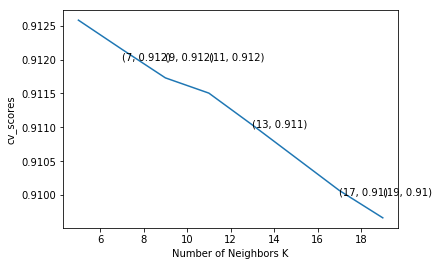

the cv_scores for each k value is :  [0.913 0.912 0.912 0.912 0.911 0.91  0.91 ]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


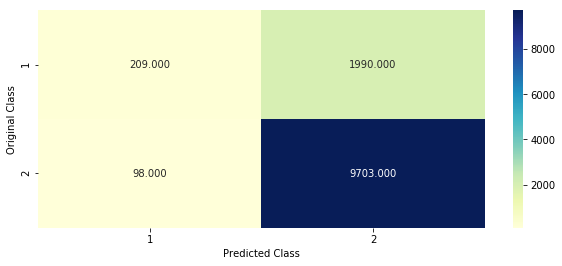


The accuracy of the knn classifier[Test data] for k = 5 is 82.600000%

The precision of the Knn classifier[Test data] for k = 5 is 82.981271%

The recall of the Knn classifier[Test data] for k = 5 is 99.000102%

The F1_score of the Knn classifier[Test data] for k = 5 is 90.285661%
--------------------------------------------------------------------------------
00:02:53


In [153]:
kdtree_brute("kd_tree",train_std_bow,cv_std_bow,test_std_bow,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

# BOW - Bruteforce

[0.9125843863597023, 0.9121536161894906, 0.911730945821855, 0.9115054378935318, 0.911034877072613, 0.9100661949326638, 0.9096612296110415]

The optimal number of neighbors is 5.


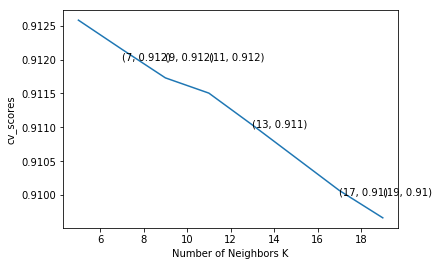

the cv_scores for each k value is :  [0.913 0.912 0.912 0.912 0.911 0.91  0.91 ]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


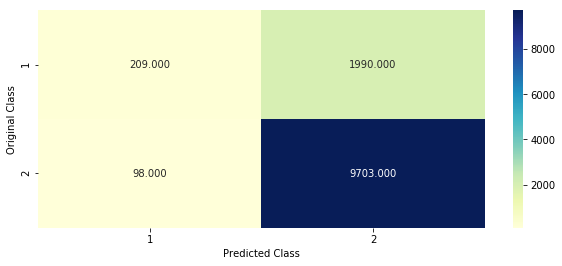


The accuracy of the knn classifier[Test data] for k = 5 is 82.600000%

The precision of the Knn classifier[Test data] for k = 5 is 82.981271%

The recall of the Knn classifier[Test data] for k = 5 is 99.000102%

The F1_score of the Knn classifier[Test data] for k = 5 is 90.285661%
--------------------------------------------------------------------------------
00:02:50


In [154]:

kdtree_brute("brute",train_std_bow,cv_std_bow,test_std_bow,y_tr,y_cv,y_test)


# TFIDF - kd tree

In [155]:
tf_idf_vect = TfidfVectorizer(min_df=50,max_features=2000)

train_tfidf = tf_idf_vect.fit_transform(train_df['Summary_CleanedText'])
cv_tfidf = tf_idf_vect.transform(cv_df['Summary_CleanedText'])
test_tfidf = tf_idf_vect.transform(test_df['Summary_CleanedText'])

train_std_tfidf = StandardScaler(with_mean=False).fit_transform(train_tfidf)
cv_std_tfidf = StandardScaler(with_mean=False).fit_transform(cv_tfidf)
test_std_tfidf = StandardScaler(with_mean=False).fit_transform(test_tfidf)

[0.9092054763132268, 0.9094650205761317, 0.909952606635071, 0.9098066061954475, 0.909567795643745, 0.9091219873511479, 0.9090184014128639]

The optimal number of neighbors is 9.


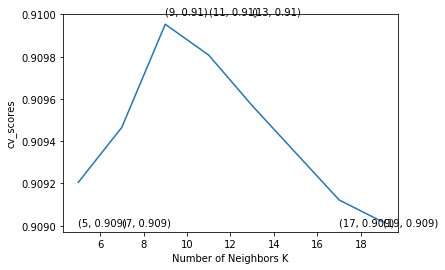

the cv_scores for each k value is :  [0.909 0.909 0.91  0.91  0.91  0.909 0.909]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


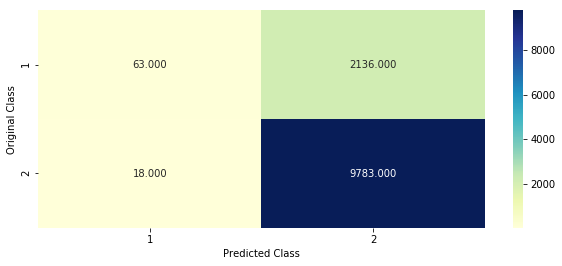


The accuracy of the knn classifier[Test data] for k = 9 is 82.050000%

The precision of the Knn classifier[Test data] for k = 9 is 82.079033%

The recall of the Knn classifier[Test data] for k = 9 is 99.816345%

The F1_score of the Knn classifier[Test data] for k = 9 is 90.082873%
--------------------------------------------------------------------------------
00:02:48


In [156]:

kdtree_brute("kd_tree",train_std_tfidf,cv_std_tfidf,test_std_tfidf,y_tr,y_cv,y_test)


# TFIDF - Bruteforce

[0.9092054763132268, 0.9094650205761317, 0.909952606635071, 0.9098066061954475, 0.909567795643745, 0.9091219873511479, 0.9090184014128639]

The optimal number of neighbors is 9.


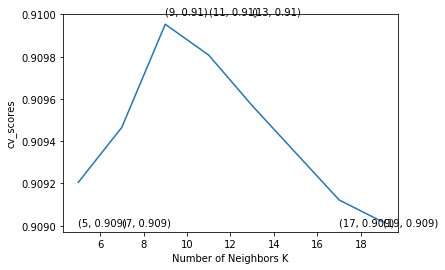

the cv_scores for each k value is :  [0.909 0.909 0.91  0.91  0.91  0.909 0.909]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


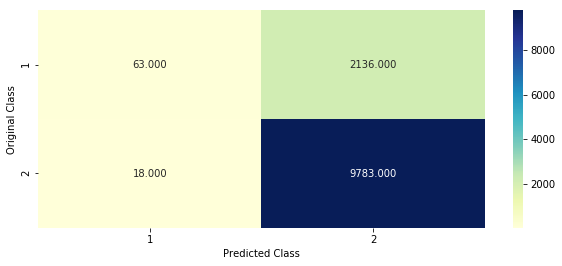


The accuracy of the knn classifier[Test data] for k = 9 is 82.050000%

The precision of the Knn classifier[Test data] for k = 9 is 82.079033%

The recall of the Knn classifier[Test data] for k = 9 is 99.816345%

The F1_score of the Knn classifier[Test data] for k = 9 is 90.082873%
--------------------------------------------------------------------------------
00:02:48


In [157]:

kdtree_brute("brute",train_std_tfidf,cv_std_tfidf,test_std_tfidf,y_tr,y_cv,y_test)


In [158]:
train_df['Summary_CleanedText'].values

array(['everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
       'whole seri great way spend time child rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live',
       'entertainingl funni beetlejuic well written movi everyth excel act special effect delight chose view movi',
       ...,
       'review real read review product like believ truth serious cereal tast aw anoth gluten free product tri base mani posit review call honey nut correct yet tast like cant even discrib word noth like ever tast give half box away wast money get disappoint new gluten free stuff think ill switch back normal food anyon make anyth gluten free isnt disgust come',
       'terribl price amazon alway excel price howev exp

# Avg-W2V

In [159]:

def avgw2v(list_of_sent):
    #list_of_sent.append(sent.split())
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors


In [160]:
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
#train_sent_vectors=[]
#cv_sent_vectors=[]
#test_sent_vectors=[]

list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

train_sent_vectors = avgw2v(list_of_sent)
    
list_of_sent=[]
for sent in cv_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
cv_sent_vectors = avgw2v(list_of_sent)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

test_sent_vectors = avgw2v(list_of_sent)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

38400
50
9600
50
12000
50
00:01:07


In [161]:
train_std_sent_vec = StandardScaler(with_mean=False).fit_transform(train_sent_vectors)
cv_std_sent_vec = StandardScaler(with_mean=False).fit_transform(cv_sent_vectors)
test_std_sent_vec = StandardScaler(with_mean=False).fit_transform(test_sent_vectors)

# Avg w2v - kd tree

[0.90694626474443, 0.9077973819009675, 0.9075075416927543, 0.9077877012344274, 0.9079740643840291, 0.9079740643840291, 0.9079740643840291]

The optimal number of neighbors is 13.


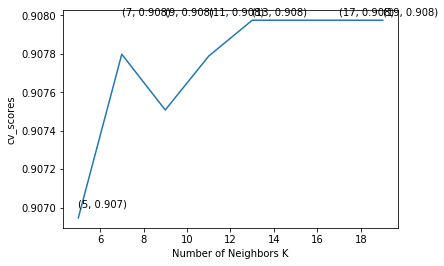

the cv_scores for each k value is :  [0.907 0.908 0.908 0.908 0.908 0.908 0.908]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


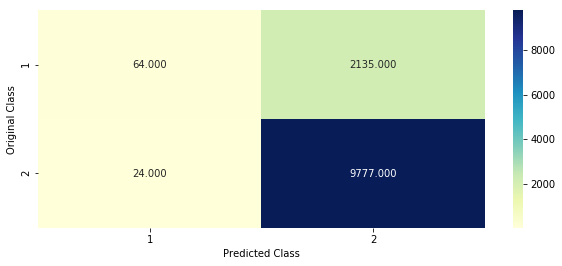


The accuracy of the knn classifier[Test data] for k = 13 is 82.008333%

The precision of the Knn classifier[Test data] for k = 13 is 82.076897%

The recall of the Knn classifier[Test data] for k = 13 is 99.755127%

The F1_score of the Knn classifier[Test data] for k = 13 is 90.056648%
--------------------------------------------------------------------------------
00:11:02


In [162]:
kdtree_brute("kd_tree",train_std_sent_vec,cv_std_sent_vec,test_std_sent_vec,y_tr,y_cv,y_test)

# Avg w2v - Bruteforce

[0.90694626474443, 0.9077973819009675, 0.9075075416927543, 0.9077877012344274, 0.9079740643840291, 0.9079740643840291, 0.9079740643840291]

The optimal number of neighbors is 13.


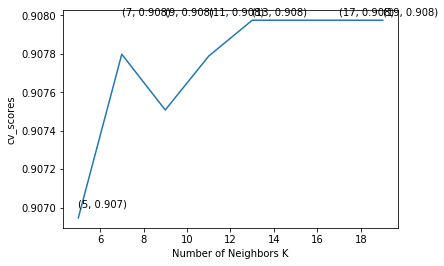

the cv_scores for each k value is :  [0.907 0.908 0.908 0.908 0.908 0.908 0.908]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


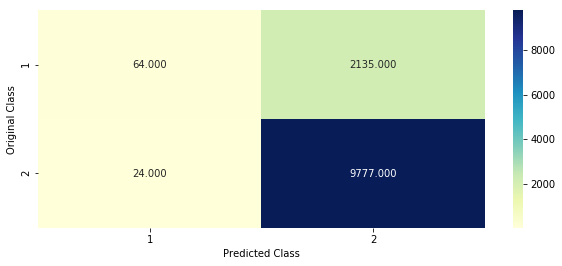


The accuracy of the knn classifier[Test data] for k = 13 is 82.008333%

The precision of the Knn classifier[Test data] for k = 13 is 82.076897%

The recall of the Knn classifier[Test data] for k = 13 is 99.755127%

The F1_score of the Knn classifier[Test data] for k = 13 is 90.056648%
--------------------------------------------------------------------------------
00:02:48


In [163]:

kdtree_brute("brute",train_std_sent_vec,cv_std_sent_vec,test_std_sent_vec,y_tr,y_cv,y_test)


# TFIDF weighted w2v

In [164]:
def tfidf_w2v(list_of_sent,dictionary):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [165]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in train_df['CleanedText'].values:
    list_of_sent.append(sent.split())
                        
tf_idf_matrix = model.fit_transform(train_df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

train_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,dictionary)
    
list_of_sent=[]
for sent in cv_df['CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.fit_transform(cv_df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model.get_feature_names(), list(model.idf_)))

cv_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,dictionary1)

list_of_sent=[]
for sent in test_df['CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.fit_transform(test_df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary2 = dict(zip(model.get_feature_names(), list(model.idf_)))

test_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,dictionary2)

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))


100%|█████████████████████████████████████████████████████████████████████| 12000/12000 [00:13<00:00, 871.04it/s]


00:01:34


In [166]:
train_std_tfidfw2v = StandardScaler(with_mean=False).fit_transform(train_tfidf_w2v_vectors)
cv_std_tfidfw2v = StandardScaler(with_mean=False).fit_transform(cv_tfidf_w2v_vectors)
test_std_tfidfw2v = StandardScaler(with_mean=False).fit_transform(test_tfidf_w2v_vectors)

# TFIDF weighted w2v - kd tree

[0.9059623849539815, 0.9070271503536391, 0.9075994075424404, 0.9079314467915504, 0.9076730418943534, 0.9079733652040294, 0.9078700278836853]

The optimal number of neighbors is 17.


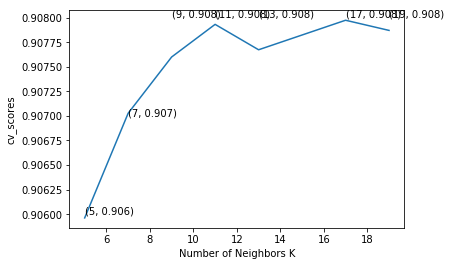

the cv_scores for each k value is :  [0.906 0.907 0.908 0.908 0.908 0.908 0.908]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


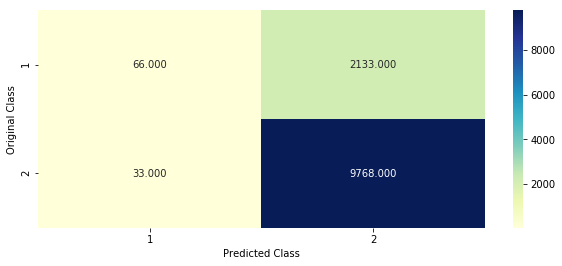


The accuracy of the knn classifier[Test data] for k = 17 is 81.950000%

The precision of the Knn classifier[Test data] for k = 17 is 82.077136%

The recall of the Knn classifier[Test data] for k = 17 is 99.663300%

The F1_score of the Knn classifier[Test data] for k = 17 is 90.019353%
--------------------------------------------------------------------------------
00:11:06


In [167]:
kdtree_brute("kd_tree",train_std_tfidfw2v,cv_std_tfidfw2v,test_std_tfidfw2v,y_tr,y_cv,y_test)

# TFIDF weighted w2v - Bruteforce

[0.9059623849539815, 0.9070271503536391, 0.9075994075424404, 0.9079314467915504, 0.9076730418943534, 0.9079733652040294, 0.9078700278836853]

The optimal number of neighbors is 17.


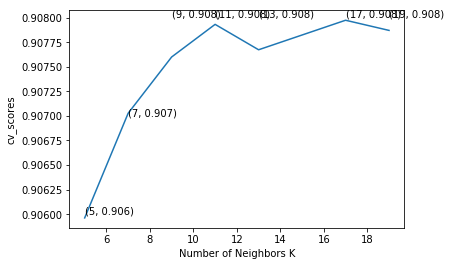

the cv_scores for each k value is :  [0.906 0.907 0.908 0.908 0.908 0.908 0.908]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


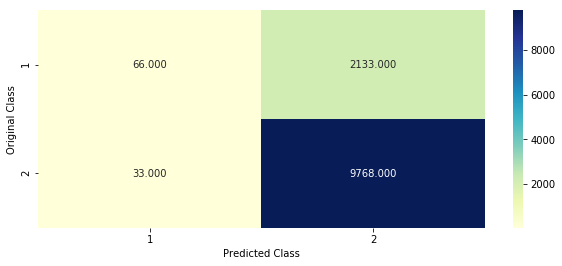


The accuracy of the knn classifier[Test data] for k = 17 is 81.950000%

The precision of the Knn classifier[Test data] for k = 17 is 82.077136%

The recall of the Knn classifier[Test data] for k = 17 is 99.663300%

The F1_score of the Knn classifier[Test data] for k = 17 is 90.019353%
--------------------------------------------------------------------------------
00:02:58


In [168]:
kdtree_brute("brute",train_std_tfidfw2v,cv_std_tfidfw2v,test_std_tfidfw2v,y_tr,y_cv,y_test)

# Conclusion:

In [170]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Algorithm", "Accuracy", "Precision", "Recall", "F1_Score"]

x.add_row(["BOW", "Brute, Kdtree", 82.60, 82.98, 99.00, 90.28])
x.add_row(["TFIDF", "Brute, Kdtree", 82.05, 82.07, 99.81, 90.08])
x.add_row(["Avg-W2V", "Brute, Kdtree", 82.00, 82.07, 99.75, 90.05])
x.add_row(["Tfidf-W2V", "Brute, Kdtree", 81.95, 82.07, 99.66, 90.01])
print(x)

+------------+---------------+----------+-----------+--------+----------+
| Vectorizer |   Algorithm   | Accuracy | Precision | Recall | F1_Score |
+------------+---------------+----------+-----------+--------+----------+
|    BOW     | Brute, Kdtree |   82.6   |   82.98   |  99.0  |  90.28   |
|   TFIDF    | Brute, Kdtree |  82.05   |   82.07   | 99.81  |  90.08   |
|  Avg-W2V   | Brute, Kdtree |   82.0   |   82.07   | 99.75  |  90.05   |
| Tfidf-W2V  | Brute, Kdtree |  81.95   |   82.07   | 99.66  |  90.01   |
+------------+---------------+----------+-----------+--------+----------+
